# **Fashion-MNIST**

# Assignment

In most real-world applications, labelled data is scarce. Suppose you are given
the Fashion-MNIST dataset (https://github.com/zalandoresearch/fashion-mnist), but without any labels
in the training set. The labels are held in a database, which you may query to reveal the label of any particular image it contains. Your task is to build a classifier to >90% accuracy on the test set, using the smallest number of queries to this >database. 

**Models Used**

This solutions use the CNN model:

# Import Libraries 

I begin by importing necessary packages, modules, and functions

In [6]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")
# import the necessary packages
#from pyimagesearch.minivggnet import MiniVGGNet
from sklearn.metrics import classification_report
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from imutils import build_montages
import matplotlib.pyplot as plt
import numpy as np
import cv2
# initialize the number of epochs to train for, base learning rate,
# and batch size
NUM_EPOCHS = 25
INIT_LR = 1e-2
BS = 32

I will be defining a very simple Convolutional Neural Network to train on the Fashion MNIST dataset. However, I will be taking advantage of batch normalization and dropout which are two methods I nearly always recommend.

In [7]:
# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K
class MiniVGGNet:
	@staticmethod
	def build(width, height, depth, classes):
		# initialize the model along with the input shape to be
		# "channels last" and the channels dimension itself
		model = Sequential()
		inputShape = (height, width, depth)
		chanDim = -1
		# if we are using "channels first", update the input shape
		# and channels dimension
		if K.image_data_format() == "channels_first":
			inputShape = (depth, height, width)
			chanDim = 1
		# first CONV => RELU => CONV => RELU => POOL layer set
		model.add(Conv2D(32, (3, 3), padding="same",
			input_shape=inputShape))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(32, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.25))
		# second CONV => RELU => CONV => RELU => POOL layer set
		model.add(Conv2D(64, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(64, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))
		model.add(Dropout(0.25))
		# first (and only) set of FC => RELU layers
		model.add(Flatten())
		model.add(Dense(512))
		model.add(Activation("relu"))
		model.add(BatchNormalization())
		model.add(Dropout(0.5))
		# softmax classifier
		model.add(Dense(classes))
		model.add(Activation("softmax"))
		# return the constructed network architecture
		return model            

The model has two sets of (CONV => RELU => BN) * 2 => POOL layers. These layer sets also include batch normalization and dropout.

Pooling layers help to progressively reduce the spatial dimensions of the input volume.

Batch normalization seeks to normalize the activations of a given input volume before passing it into the next layer. It is effective at reducing the number of epochs required to train a CNN at the expense of an increase in per-epoch time.

Dropout is a form of regularization that aims to prevent overfitting. Random connections are dropped to ensure that no single node in the network is responsible for activating when presented with a given pattern.

What follows is a fully-connected layer and softmax classifier. The softmax classifier is used to obtain output classification probabilities

# Get Data

In [4]:
from tensorflow.keras.datasets import fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


The dataset is loaded  and reshaped

In [8]:
# grab the Fashion MNIST dataset (if this is your first time running
# this the dataset will be automatically downloaded)
print("[INFO] loading Fashion MNIST...")
((trainX, trainY), (testX, testY)) = fashion_mnist.load_data()
# if we are using "channels first" ordering, then reshape the design
# matrix such that the matrix is:
# 	num_samples x depth x rows x columns
if K.image_data_format() == "channels_first":
	trainX = trainX.reshape((trainX.shape[0], 1, 28, 28))
	testX = testX.reshape((testX.shape[0], 1, 28, 28))
 
# otherwise, we are using "channels last" ordering, so the design
# matrix shape should be: num_samples x rows x columns x depth
else:
	trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
	testX = testX.reshape((testX.shape[0], 28, 28, 1))

[INFO] loading Fashion MNIST...


# Pre-Processing

In [9]:
# scale data to the range of [0, 1]
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0
# one-hot encode the training and testing labels
trainY = to_categorical(trainY, 10)
testY = to_categorical(testY, 10)
# initialize the label names
labelNames = ["top", "trouser", "pullover", "dress", "coat",
	"sandal", "shirt", "sneaker", "bag", "ankle boot"]

Here the pixel intensities are scaled to the range [0, 1]. I then one-hot encode the labels.

In [10]:
# initialize the optimizer and model
print("[INFO] compiling model...")
opt = SGD(lr=INIT_LR, momentum=0.9, decay=INIT_LR / NUM_EPOCHS)
model = MiniVGGNet.build(width=28, height=28, depth=1, classes=10)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])
# train the network
print("[INFO] training model...")
H = model.fit(x=trainX, y=trainY,
	validation_data=(testX, testY),
	batch_size=BS, epochs=NUM_EPOCHS)

[INFO] compiling model...


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


[INFO] training model...
Epoch 1/25
1875/1875 [==============================] - 198s 105ms/step - loss: 0.5397 - accuracy: 0.8199 - val_loss: 0.3651 - val_accuracy: 0.8707
Epoch 2/25
1875/1875 [==============================] - 197s 105ms/step - loss: 0.3422 - accuracy: 0.8777 - val_loss: 0.2795 - val_accuracy: 0.8976
Epoch 3/25
1875/1875 [==============================] - 196s 105ms/step - loss: 0.2965 - accuracy: 0.8926 - val_loss: 0.2579 - val_accuracy: 0.9052
Epoch 4/25
1875/1875 [==============================] - 197s 105ms/step - loss: 0.2699 - accuracy: 0.9027 - val_loss: 0.2444 - val_accuracy: 0.9098
Epoch 5/25
1875/1875 [==============================] - 196s 105ms/step - loss: 0.2523 - accuracy: 0.9085 - val_loss: 0.2229 - val_accuracy: 0.9185
Epoch 6/25
1875/1875 [==============================] - 197s 105ms/step - loss: 0.2411 - accuracy: 0.9114 - val_loss: 0.2195 - val_accuracy: 0.9196
Epoch 7/25
1875/1875 [==============================] - 198s 105ms/step - loss: 0.2316 

I initialized and compiled the model with the Stochastic Gradient Descent (SGD ) optimizer and learning rate decay.From there the model is trained via the call to model.fit.After training for NUM_EPOCHS , I then evaluate the  network and generate a training plot:

In [11]:
# make predictions on the test set
preds = model.predict(testX)
# show a nicely formatted classification report
print("[INFO] evaluating network...")
print(classification_report(testY.argmax(axis=1), preds.argmax(axis=1),
	target_names=labelNames))
# plot the training loss and accuracy
N = NUM_EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

[INFO] evaluating network...
              precision    recall  f1-score   support

         top       0.90      0.88      0.89      1000
     trouser       1.00      0.98      0.99      1000
    pullover       0.91      0.89      0.90      1000
       dress       0.92      0.94      0.93      1000
        coat       0.86      0.92      0.89      1000
      sandal       0.99      0.99      0.99      1000
       shirt       0.80      0.78      0.79      1000
     sneaker       0.96      0.98      0.97      1000
         bag       0.99      0.99      0.99      1000
  ankle boot       0.98      0.97      0.97      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



# Visualize Result

Now let’s add a colored label to each image and arrange them in a montage:

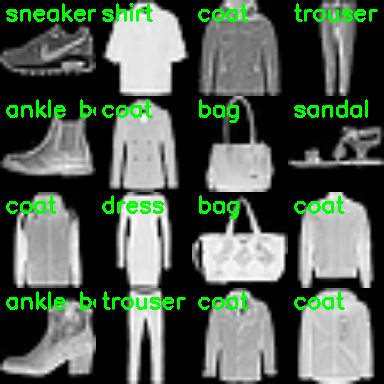

-1

In [21]:
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
# initialize our list of output images
images = []
# randomly select a few testing fashion items
for i in np.random.choice(np.arange(0, len(testY)), size=(16,)):
	# classify the clothing
	probs = model.predict(testX[np.newaxis, i])
	prediction = probs.argmax(axis=1)
	label = labelNames[prediction[0]]
 
	# extract the image from the testData if using "channels_first"
	# ordering
	if K.image_data_format() == "channels_first":
		image = (testX[i][0] * 255).astype("uint8")
 
	# otherwise we are using "channels_last" ordering
	else:
		image = (testX[i] * 255).astype("uint8")
	# initialize the text label color as green (correct)
	color = (0, 255, 0)
	# otherwise, the class label prediction is incorrect
	if prediction[0] != np.argmax(testY[i]):
		color = (0, 0, 255)
 
	# merge the channels into one image and resize the image from
	# 28x28 to 96x96 so we can better see it and then draw the
	# predicted label on the image
	image = cv2.merge([image] * 3)
	image = cv2.resize(image, (96, 96), interpolation=cv2.INTER_LINEAR)
	cv2.putText(image, label, (5, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.75,
		color, 2)
	# add the image to our list of output images
	images.append(image)
# construct the montage for the images
montage = build_montages(images, (96, 96), (4, 4))[0]
# show the output montage

cv2_imshow(montage)
cv2.waitKey(0)  